<a href="https://colab.research.google.com/github/Soothysay/Automated-ANN/blob/master/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten,Dense,Activation,Embedding,LeakyReLU,BatchNormalization,Dropout
from keras.activations import relu,sigmoid,elu,softmax,tanh
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras import losses
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [0]:
def divide(path,divider):
  #Division of X and Y
  x=path.drop(divider,axis=1)
  type(divider)
  y=path[divider]
  return x,y

In [0]:
# Splitting the dataset into the Training set and Test set
def splitter(x,y):
  
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
  # Feature Scaling
  sc = StandardScaler()
  x_train = sc.fit_transform(x_train)
  x_test = sc.transform(x_test)
  return x_train,y_train,x_test,y_test

In [0]:
def read():
  df=pd.read_csv('/content/drive/My Drive/ANN/PS_20174392719_1491204439457_log.csv')
  # list of columns whose data type is object i.e. string
  listOfColumnNames = list((df.dtypes[df.dtypes == np.object]).index)
  #filteredColumns = df.dtypes[df.dtypes == np.object]
  #listOfColumnNames = list(filteredColumns.index)
  #Removing the Name and Surname Columns (You can add more redundant parameters)
  if 'nameOrig' in listOfColumnNames:
    df=df.drop(['nameOrig'],axis=1)
  if 'nameDest' in listOfColumnNames:
    df=df.drop(['nameDest'],axis=1)
  if 'nameOrig' in listOfColumnNames:
    listOfColumnNames.remove('nameOrig')
  if 'nameDest' in listOfColumnNames:
    listOfColumnNames.remove('nameDest')
  #Replacing the object type values with classified values (Performance can be improved)
  for i in range(len(listOfColumnNames)):
    s=set(df[listOfColumnNames[i]])
    s=list(s)
    for j in range(len(s)):
      df=df.replace(to_replace=s[j],value=(j+1))
  #Done with data shaping
  return df

In [0]:
def main():
  df=read()
  while True:
    print("Ready to work?(Y/N)")
    work=input()
    if(work=='N'):
      break
    
    print("Enter the column you wish to use as  result")
    print("Your options are:",df.columns)
    divider=input()
    #We need to preprocess data a bit more if data is biased towards a particular outcome
    nonf=df[df[divider]==0]
    fra=df[df[divider]==1]
    #I have just taken 10. The value can change
    if nonf.shape>=(10*fra.shape): 
      nonf=nonf.sample(fra.shape[0])
      #print(nonf.shape)
      df=fra.append(nonf,ignore_index=True)
    if fra.shape>=(10*nonf.shape):
      fra=fra.sample(nonf.shape[0])
      #print(fra.shape)
      df=nonf.append(fra,ignore_index=True)
    #Dividing dataset to x and y
    x,y=divide(df,divider)
    #Scaling the dataset and division of training and test dataset
    x_train,y_train,x_test,y_test=splitter(x,y)
    print("Number of layers you want") #Between 2 to 9
    nl=int(input())
    nodes=list()
    for i in range(nl):
      nodes.append(int(input("Enter number of neurons in layer: ")))
    epochs=int(input("Enter the number of epochs you want"))
    bs=int(input("Enter the batch size you want"))
    spl=int(input("Enter the percentage of data you want to use for validation"))
    spl=spl*0.01
    print("Choose the activation function for your layers")
    print("1. sigmoid")
    print("2. relu (Recommended. Most worked activation function in industry)")
    print("3. tanh")
    print("4. softmax")
    activation=input()
    n=int(input("Enter percentage of dropout"))
    n=n*0.01
    model=binary_class(x_train,nodes,activation,n)
    print("Enter optimizer:")
    print("1. sgd")
    print("2. Adam (Hyperparameter tuning shows best)")
    print( "3. Adamax")
    print("4. Nadam")
    opt=input()
    #model_history=model.fit(x_train, y_train,validation_split=spl, batch_size = bs,epochs = epochs)
    m1,m=optibin(model,opt,x_train,y_train,spl,bs,epochs)
    print(m1.history.keys())
    plotter(m1)
    cm,score=crossmat(m,x_test,y_test)
    print(cm)
    print(score)
  print("Thank You!")
  

In [0]:
def plotter(model):
  #Summarize history for accuracy
  plt.plot(model.history['accuracy'])
  plt.plot(model.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  #Summarize history for loss
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


In [0]:
def optibin(model,opt,x_train,y_train,spl,bs,epochs):
  if(opt=='sgd'):
    print("Enter Momentum:")
    mom=float(input())
    lr=float(input("Enter value of Learning rate:"))
    sgd=keras.optimizers.SGD(learning_rate=lr, momentum=mom, nesterov=False)
    model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])
  if(opt=='Adam'):
    lr=float(input("Enter value of Learning rate:"))
    adam=keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
  if(opt=='Adamax'):
    lr=float(input("Enter value of Learning rate:"))
    beta_1=float(input("Enter value of beta 1 (Generally close to 1)"))
    beta_2=float(input("Enter value of beta 2 (Generally close to 1)"))
    adamax=keras.optimizers.Adamax(learning_rate=lr, beta_1=beta_1, beta_2=beta_2)
    model.compile(optimizer = adamax, loss = 'binary_crossentropy', metrics = ['accuracy'])
  if(opt=='Nadam'):
    lr=float(input("Enter value of Learning rate:"))
    beta_1=float(input("Enter value of beta 1 (Generally close to 1)"))
    beta_2=float(input("Enter value of beta 2 (Generally close to 1)"))
    nadam=keras.optimizers.Nadam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2)
    model.compile(optimizer = nadam, loss = 'binary_crossentropy', metrics = ['accuracy'])
  model_history=model.fit(x_train, y_train,validation_split=spl, batch_size = bs,epochs = epochs)
  return model_history, model
 # model.compile(optimizer = 'Adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [0]:
def binary_class(x_train,nodes,activation,n):
  model=Sequential()
  for i in range(len(nodes)):
    if(i==0):
      if(activation=='sigmoid'):
        model.add(Dense(units = nodes[i], kernel_initializer = 'glorot_uniform',activation='sigmoid',input_dim = len(x_train[1])))
      if(activation=='relu'):
        model.add(Dense(units = nodes[i], kernel_initializer = 'he_uniform',activation='relu',input_dim = len(x_train[1])))
      if(activation=='tanh'):
        model.add(Dense(units = nodes[i], kernel_initializer = 'glorot_normal',activation='tanh',input_dim = len(x_train[1])))
      if(activation=='softmax'):
        model.add(Dense(units = nodes[i], kernel_initializer = 'glorot_normal',activation='softmax',input_dim = len(x_train[1])))
    else:
      if(activation=='sigmoid'):
        model.add(Dense(units = nodes[i], kernel_initializer = 'glorot_uniform',activation='sigmoid'))
      if(activation=='relu'):
        model.add(Dense(units = nodes[i], kernel_initializer = 'he_uniform',activation='relu'))
      if(activation=='tanh'):
        model.add(Dense(units = nodes[i], kernel_initializer = 'glorot_normal',activation='tanh'))
      if(activation=='softmax'):
        model.add(Dense(units = nodes[i], kernel_initializer = 'glorot_uniform',activation='softmax'))
    model.add(Dropout(n))
  #Adding output layer
  model.add(Dense(units=1, kernel_initializer = 'glorot_uniform',activation='sigmoid'))
  #model.compile(optimizer = 'Adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

In [0]:
def crossmat(m,x_test,y_test):
  y_pred = m.predict(x_test)
  y_pred = (y_pred > 0.5)
  from sklearn.metrics import confusion_matrix
  cm = confusion_matrix(y_test, y_pred)
  # Calculate the Accuracy
  from sklearn.metrics import accuracy_score
  score=accuracy_score(y_pred,y_test)
  return cm,score

Ready to work?(Y/N)
Y
Enter the column you wish to use as  result
Your options are: Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')
isFraud
Number of layers you want
2
Enter number of neurons in layer: 7
Enter number of neurons in layer: 6
Enter the number of epochs you want15
Enter the batch size you want10
Enter the percentage of data you want to use for validation43
Choose the activation function for your layers
1. sigmoid
2. relu (Recommended. Most worked activation function in industry)
3. tanh
4. softmax
relu
Enter percentage of dropout10
Enter optimizer:
1. sgd
2. Adam (Hyperparameter tuning shows best)
3. Adamax
4. Nadam
Adam
Enter value of Learning rate:0.02
Train on 7489 samples, validate on 5651 samples
Epoch 1/15
7489/7489 [==============================] - 1s 182us/step - loss: 0.3470 - accuracy: 0.8518 - val_loss: 0.2808 - val_accuracy: 0.8623
Epoch 2/15
7489

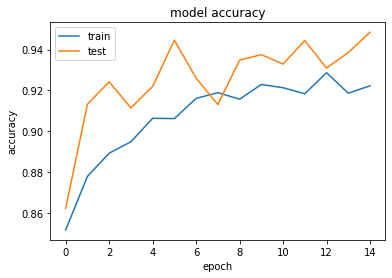

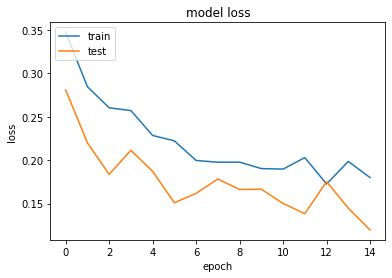

[[1594   62]
 [  93 1537]]
0.9528301886792453
Ready to work?(Y/N)
N
Thank You!


In [40]:
main()